<a href="https://colab.research.google.com/github/ozgesengil/fMRI_Analysis_Scripts/blob/main/GLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#General Linear Model - GLM
Let's start with defining the HRF, and BOLD response as convolution of neural response and the HRF. We will use gamma and double-gamma models for HRF in this example

In [ ]:
from scipy.stats import gamma, norm, t
import matplotlib.pyplot as plt
import numpy as np

def hrf_double_gamma(t,n1,n2,lmbd1,lmbd2,t01,t02,a):
  c = (gamma.cdf(t[t.size-1],n1,loc=t01,scale=lmbd1)
        - a * gamma.cdf(t[t.size-1],n2,loc=t02,scale=lmbd2))
  return ( 1/c * (gamma.pdf(t,n1,scale=lmbd1,loc=t01)
                   - a * gamma.pdf(t,n2,scale=lmbd2,loc=t02)))

def hrf_single_gamma(t,n,lmbd,t0):
  return gamma.pdf(t,n,loc=t0,scale=lmbd)

def bold_response(n, h):
  return np.convolve(n,h)

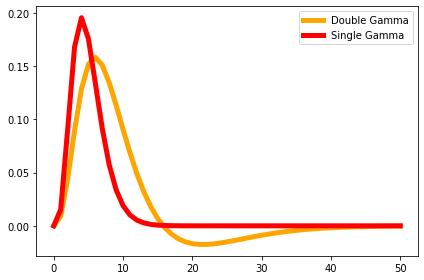

In [ ]:
#@title Gamma & Double-Gamma HIRF
time = np.arange(0, 51, 1.0)
# parameters for single and double gamma distribution functions
n = 5
lmbd = 1
t0 = 0
bold_single_gamma = hrf_single_gamma(time, n, lmbd, t0)

n1 = 4
lmbd1 = 2
t01 = 0
n2 = 7
lmbd2 = 3
t02 = 0
a = 0.3
bold_double_gamma = hrf_double_gamma(time, n1, n2, lmbd1, lmbd2, t01, t02, a)

plt.plot(time, bold_double_gamma,
         color = 'orange', linewidth = 5, label="Double Gamma")
plt.plot(time, bold_single_gamma,
        color = 'red', linewidth = 5, label="Single Gamma")
plt.legend()
plt.tight_layout()
plt.show()


As usual, let's define the neural response as a series of boxcars

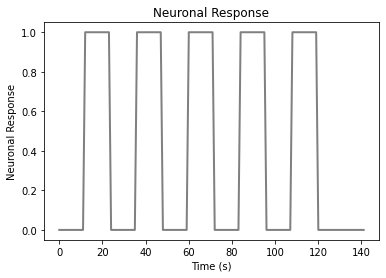

In [ ]:
#@title A boxcar neuronal response

onset = 12 #@param {type:"integer"}
active_duration = 12 #@param {type:"integer"}
rest_duration = 12 #@param {type:"integer"}
block_duration = active_duration+rest_duration
number_of_blocks = 5 #@param {type:"integer"}
final_rest = 10 #@param {type:"integer"}
box = np.zeros(onset + block_duration*number_of_blocks+final_rest)
block_start = np.arange(onset, number_of_blocks*block_duration, block_duration)
for start in block_start:
  box[start:start+active_duration] = np.ones(active_duration)
box[box.size-final_rest:box.size] = np.zeros(final_rest)

plt.plot(box, color='gray', linestyle='solid', linewidth=2)
plt.title("Neuronal Response")
plt.xlabel("Time (s)")
plt.ylabel("Neuronal Response")
plt.show()

Next we simulate BOLD response using the following model

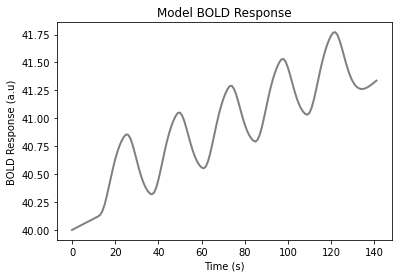

In [ ]:
HRF = 'Double-Gamma' #@param ['Single-Gamma','Double-Gamma']
if HRF=="Single-Gamma":
  h = bold_single_gamma
elif HRF=="Double-Gamma":
  h = bold_double_gamma

beta =  0.5#@param {type:"raw"} # the "correlation"
B0 = 40 #@param {type:"integer"} # mean
Delta = 0.01 #@param {type:"raw"} # Linear drift

model = beta * bold_response(box, h) + B0
model += np.arange(0,model.size)*Delta
model = model[0:box.size]

plt.plot(model, color='gray', linestyle='solid', linewidth=2)
plt.title("Model BOLD Response")
plt.xlabel("Time (s)")
plt.ylabel("BOLD Response (a.u)")
plt.show()

Here is the simulated BOLD response with noise added

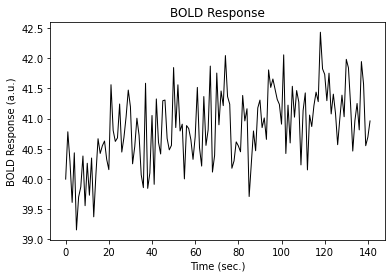

In [ ]:
noise_sigma =  0.5#@param {type:"raw"};
bold = model + norm.rvs(scale = noise_sigma, size = model.size)
plt.plot(bold, color='black', linestyle='solid', linewidth=1)
plt.title('BOLD Response')
plt.xlabel('Time (sec.)')
plt.ylabel('BOLD Response (a.u.)')
plt.show()

##Solution With GLM
First, let's define the design matrix. Recall that design matrix **A** is the first matrix on the right side of the equation

$$
 \begin{bmatrix}
  B(TR_1) \\
  B(TR_2) \\
  B(TR_3) \\
  B(TR_4) \\
  B(TR_5) \\
  B(TR_6) \\
  B(TR_7) \\
  B(TR_8) \\
  \ldots\\
 \end{bmatrix}
 =
 \begin{bmatrix}
  x(TR_1) & 1 & 1\\
  x(TR_2) & 1 & 2\\
  x(TR_3) & 1 & 3\\
  x(TR_4) & 1 & 4\\
  x(TR_5) & 1 & 5\\
  x(TR_6) & 1 & 6\\
  x(TR_7) & 1 & 7\\
  x(TR_8) & 1 & 8\\
  \ldots & \ldots & \ldots\\
 \end{bmatrix}
 \times
 \begin{bmatrix}
  \beta\\
  B_0\\
  \Delta
 \end{bmatrix}
 +
 \begin{bmatrix}
  \epsilon_1\\
  \epsilon_2\\
  \epsilon_3\\
  \epsilon_4\\
  \epsilon_5\\
  \epsilon_6\\
  \epsilon_7\\
  \epsilon_8\\
  \ldots\\
 \end{bmatrix},
 $$
 or
 $$ \mathbf{Y} = \mathbf{A} \mathbf{B} + \mathbf{e} $$

In [ ]:
#@title Design Matrix
HRF = 'Single-Gamma' #@param ['Single-Gamma','Double-Gamma']
if HRF=="Single-Gamma":
  h = bold_single_gamma
elif HRF=="Double-Gamma":
  h = bold_double_gamma

x1 = bold_response(box, h)

AT = np.vstack([x1[0:box.size], # Transpose of the design matrix. A-transpose
               np.ones(box.size),
               np.arange(1,box.size+1,1)])
A = AT.T   # A, the design matrix. constructing first the transpose is more convinient

Next, using this design matrix, let's estimate the beta weights using the formula
$$\widehat{\mathbf{B}} = (\mathbf{A}^\prime \mathbf{A})^{-1} \mathbf{A}^\prime \, \mathbf{Y},$$
and the unbiased estimator of $\sigma_\epsilon^2$:
$$ \hat{\sigma}_\epsilon^2 =\frac{1}{df_E} (\mathbf{Y}-\mathbf{A} \widehat{\mathbf{B}})^\prime \times (\mathbf{Y}-\mathbf{A} \widehat{\mathbf{B}}) $$
 where $dF_E$ is the degrees of freedom = number of TRs - number of parameters in $\mathbf{B}$.

In [ ]:
B_hat = (np.linalg.inv(AT.dot(A)).dot(AT)).dot(bold)
BT_hat = B_hat.T
error = bold-A.dot(B_hat)
dof = box.size-B_hat.size # degrees of freedom
noise_sigma_hat = np.sqrt( (error.T).dot(error) / dof )
print ('beta_hat = \n', B_hat)
print ('noise_sigma_hat = %6.3f' % noise_sigma_hat)

beta_hat = 
 [5.38423166e-01 4.00706123e+01 7.77824643e-03]
noise_sigma_hat =  0.489


Compare these values with the original ones. Are they close? Next, let's plot together the original model (groundtruth) and the model that GLM found

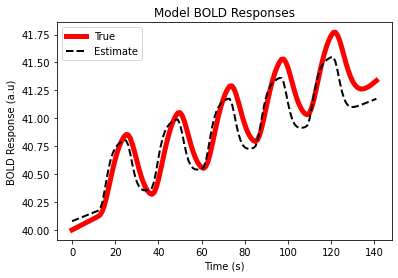

In [ ]:
plt.plot(model, color='red', linestyle='solid', linewidth=5, label='True')
plt.title("Model BOLD Responses")
plt.xlabel("Time (s)")
plt.ylabel("BOLD Response (a.u)")

model_est = A.dot(B_hat)

plt.plot(model_est, color='black', linestyle='dashed', linewidth=2, label='Estimate')
plt.legend()

plt.show()

Finally, let's do the t-test. Recall that any null hypothesis under test can be written as:
$$H_0: \mathbf{c}^\prime \mathbf{B} = 0.$$
For example if $H_0: \beta = 0$, then
$$ H_0: \begin{bmatrix}
       1 & 0 & 0
      \end{bmatrix}
      \begin{bmatrix}
       \beta\\
       B_0\\
       \Delta\\
      \end{bmatrix}
      = 0
$$
Thus, $H_0: \mathbf{c}^\prime \mathbf{B} = 0 $ with $ \mathbf{c}^\prime = \begin{bmatrix} 1 & 0 & 0 \end{bmatrix}$.

Then the value
$$t = \frac{\mathbf{c}^\prime \mathbf{B}}{\sqrt{\hat{\sigma}_\epsilon^2 \mathbf{c}^\prime (\mathbf{A}^\prime \mathbf{A})^{-1} \mathbf{c} }}$$

has a $t$-distribution with d.o.f = number of TRs - number of parameters in $\mathbf{B}$

In [ ]:
c = np.array([[1],[0],[0]])
cT = c.T
t_stat = cT.dot(B_hat) / np.sqrt(
            np.square(noise_sigma_hat) *
            cT.dot(np.linalg.inv(AT.dot(A))).dot(c) )
p_uncorrected = t.sf(t_stat, dof)
print ('t-statistic = %6.3f; uncorrected p-value = %e' % (t_stat, p_uncorrected))

t-statistic =  5.222; uncorrected p-value = 3.157508e-07


##Things to do


1. FBR method
2. Visualize the design matrix
